# Fitting go/no-go using the chi-qsuare approach
## by Jan Willem de Gee (jwdegee@gmail.com)

This is a demo of fitting go/no-go data with HDDM using the chi-qsuare method, as described in 

    de Gee JW, Tsetsos T, McCormick DA, McGinley MJ & Donner TH. 2018. Phasic arousal optimizes decision computations in mice and humans. bioRxiv. (https://www.biorxiv.org/content/early/2018/10/19/447656).
    

See also
    
    Ratcliff, R., Huang-Pollock, C., & McKoon, G. (2016). Modeling individual differences in the go/no-go task with a diffusion model. Decision, 5(1), 42-62 (http://psycnet.apa.org/record/2016-39470-001).

In [4]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from joblib import Parallel, delayed
from IPython import embed as shell

Let's start with defining some functionality

In [30]:
def get_choice(row):
    
    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0

def simulate_data(a, v, t, z, dc, sv=0, sz=0, st=0, condition=0, nr_trials1=1000, nr_trials2=1000):
    
    """
    Simulates stim-coded data.
    """
    
    parameters1 = {'a':a, 'v':v+dc, 't':t, 'z':z, 'sv':sv, 'sz': sz, 'st': st}
    parameters2 = {'a':a, 'v':v-dc, 't':t, 'z':1-z, 'sv':sv, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=1, subj_noise=0)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=1, subj_noise=0)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])
    
    return df_sim

def fit_subject(data, quantiles):
    
    """
    Simulates stim-coded data.
    """
    
    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, stim_col='stimulus', split_param='v', drift_criterion=True, bias=True, p_outlier=0,
                            depends_on={'v':'condition', 'a':'condition', 't':'condition', 'z':'condition', 'dc':'condition', })
    m.optimize('gsquare', quantiles=quantiles, n_runs=8)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

def summary_plot(df_group, df_sim_group=None, quantiles=[0, 0.1, 0.3, 0.5, 0.7, 0.9,], xlim=None):

    # # remove NaNs:
    # df = df.loc[~pd.isna(df.rt),:]
    # if df_sim is not None:
    #     df_sim = df_sim.loc[~pd.isna(df_sim.rt),:]

    nr_subjects = len(np.unique(df_group['subj_idx']))

    fig = plt.figure(figsize=(10,nr_subjects*2))
    plt_nr = 1
    for s in np.unique(df_group['subj_idx']):
        
        print(s)

        df = df_group.copy().loc[(df_group['subj_idx']==s),:]
        df_sim = df_sim_group.copy().loc[(df_sim_group['subj_idx']==s),:]
        df['rt_acc'] = df['rt'].copy()
        df.loc[df['correct']==0, 'rt_acc'] = df.loc[df['correct']==0, 'rt_acc'] * -1
        df['rt_resp'] = df['rt'].copy()
        df.loc[df['response']==0, 'rt_resp'] = df.loc[df['response']==0, 'rt_resp'] * -1
        df_sim['rt_acc'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['correct']==0, 'rt_acc'] = df_sim.loc[df_sim['correct']==0, 'rt_acc'] * -1
        df_sim['rt_resp'] = df_sim['rt'].copy()
        df_sim.loc[df_sim['response']==0, 'rt_resp'] = df_sim.loc[df_sim['response']==0, 'rt_resp'] * -1
        max_rt = np.percentile(df_sim.loc[~np.isnan(df_sim['rt']), 'rt'], 99)
        bins = np.linspace(-max_rt,max_rt,21)
        
        # rt distributions correct vs error:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        N, bins, patches = ax.hist(df.loc[:, 'rt_acc'], bins=bins, 
                                   density=True, color='green', alpha=0.5)       
        for bin_size, bin, patch in zip(N, bins, patches):
            if bin < 0:
                plt.setp(patch, 'facecolor', 'r')
        if df_sim is not None:
            ax.hist(df_sim.loc[:, 'rt_acc'], bins=bins, density=True, 
                    histtype='step', color='k', alpha=1, label=None)   
        ax.set_title('P(correct)={}'.format(round(df.loc[:, 'correct'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1

        # condition accuracy plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "correct"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0, 1)
        ax.set_title('Conditional accuracy')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(correct)')
        plt_nr += 1
        
        # rt distributions response 1 vs 0:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        if np.isnan(df['rt']).sum() > 0:
            bar_width = 1
            fraction_yes = df['response'].mean()
            fraction_yes_sim = df_sim['response'].mean()
            hist, edges = np.histogram(df.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist = hist * fraction_yes
            hist_sim, edges_sim = np.histogram(df_sim.loc[:, 'rt_resp'], bins=bins, density=True,)
            hist_sim = hist_sim * fraction_yes_sim
            ax.bar(edges[:-1], hist, width=np.diff(edges)[0], align='edge', 
                   color='magenta', alpha=0.5, linewidth=0,)
            # ax.plot(edges_sim[:-1], hist_sim, color='k', lw=1)
            ax.step(edges_sim[:-1]+np.diff(edges)[0], hist_sim, color='black', lw=1)
            # ax.hist(hist, edges, histtype='stepfilled', color='magenta', alpha=0.5, label='response')
            # ax.hist(hist_sim, edges_sim, histtype='step', color='k',)
            no_height = (1 - fraction_yes) / bar_width 
            no_height_sim = (1 - fraction_yes_sim) / bar_width 
            ax.bar(x=-1.5, height=no_height, width=bar_width, alpha=0.5, color='cyan', align='center')
            ax.hlines(y=no_height_sim, xmin=-2, xmax=-1, lw=0.5, colors='black',)
            ax.vlines(x=-2, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
            ax.vlines(x=-1, ymin=0, ymax=no_height_sim, lw=0.5, colors='black')
        else:
            N, bins, patches = ax.hist(df.loc[:, 'rt_resp'], bins=bins, 
                                   density=True, color='magenta', alpha=0.5)       
            for bin_size, bin, patch in zip(N, bins, patches):
                if bin < 0:
                    plt.setp(patch, 'facecolor', 'cyan')
            ax.hist(df_sim.loc[:, 'rt_resp'], bins=bins, density=True, 
                    histtype='step', color='k', alpha=1, label=None) 
        ax.set_title('P(bias)={}'.format(round(df.loc[:, 'response'].mean(), 3),))
        ax.set_xlabel('RT (s)')
        ax.set_ylabel('Trials (prob. dens.)')
        plt_nr += 1
        
        # condition response plots:
        ax = fig.add_subplot(nr_subjects,4,plt_nr)
        df.loc[:,'rt_bin'] = pd.qcut(df['rt'], quantiles, labels=False)
        d = df.groupby(['rt_bin']).mean().reset_index()
        ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='-o', color='orange', markersize=10)
        if df_sim is not None:
            df_sim.loc[:,'rt_bin'] = pd.qcut(df_sim['rt'], quantiles, labels=False)
            d = df_sim.groupby(['rt_bin']).mean().reset_index()
            ax.errorbar(d.loc[:, "rt"], d.loc[:, "response"], fmt='x', color='k', markersize=6)
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0,1)
        ax.set_title('Conditional response')
        ax.set_xlabel('RT (quantiles)')
        ax.set_ylabel('P(bias)')
        plt_nr += 1
        
    sns.despine(offset=3, trim=True)
    plt.tight_layout()

    return fig    

Let's simulate our own data, so we know what the fitting procedure should converge on:

In [6]:
# settings
go_nogo = True # should we put all RTs for one choice alternative to NaN (go-no data)?
n_subjects = 4
trials_per_level = 10000

# parameters:
params0 = {'cond':0, 'v':0.5, 'a':2.0, 't':0.3, 'z':0.5, 'dc':-0.2, 'sz':0, 'st':0, 'sv':0}
params1 = {'cond':1, 'v':0.5, 'a':2.0, 't':0.3, 'z':0.5, 'dc':0.2, 'sz':0, 'st':0, 'sv':0}

# simulate:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'], 
                        t=params0['t'], sv=params0['sv'], st=params0['st'], sz=params0['sz'], 
                        condition=params0['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'], 
                        t=params1['t'], sv=params1['sv'], st=params1['st'], sz=params1['sz'], 
                        condition=params1['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = i
    dfs.append(df)

# combine in one dataframe:
df_emp = pd.concat(dfs)
if go_nogo:
    df_emp.loc[df_emp["response"]==0, 'rt'] = np.NaN

Fit using the g-quare method.

In [7]:
# fit chi-square:
quantiles = [.1, .3, .5, .7, .9]
params_fitted = pd.concat(Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data[1], quantiles) 
                                                      for data in df_emp.groupby('subj_idx')))
print(params_fitted.head())

       a(0)      a(1)      v(0)      v(1)      t(0)      t(1)  z_trans(0)  \
0  2.014264  1.982307  0.491241  0.500920  0.302303  0.303157    0.017545   
1  2.012188  1.991561  0.500171  0.507074  0.321398  0.305079    0.112512   
2  2.026892  1.979547  0.497864  0.509328  0.313958  0.303418    0.087991   
3  2.001516  2.002651  0.501016  0.514810  0.305864  0.311847    0.046943   

   z_trans(1)      z(0)      z(1)     dc(0)     dc(1)            bic  \
0   -0.005189  0.504386  0.498703 -0.208985  0.201551  115950.224101   
1    0.012872  0.528098  0.503218 -0.258731  0.204944  116056.073161   
2   -0.016963  0.521984  0.495759 -0.236325  0.191737  115756.146165   
3    0.054819  0.511734  0.513701 -0.241030  0.177703  115425.608585   

      likelihood     penalty  
0 -115823.064484  127.159617  
1 -115928.913544  127.159617  
2 -115628.986548  127.159617  
3 -115298.448968  127.159617  


In [8]:
params_fitted.drop(['bic', 'likelihood', 'penalty', 'z_trans(0)', 'z_trans(1)'], axis=1, inplace=True)
print(params_fitted.head())

       a(0)      a(1)      v(0)      v(1)      t(0)      t(1)      z(0)  \
0  2.014264  1.982307  0.491241  0.500920  0.302303  0.303157  0.504386   
1  2.012188  1.991561  0.500171  0.507074  0.321398  0.305079  0.528098   
2  2.026892  1.979547  0.497864  0.509328  0.313958  0.303418  0.521984   
3  2.001516  2.002651  0.501016  0.514810  0.305864  0.311847  0.511734   

       z(1)     dc(0)     dc(1)  
0  0.498703 -0.208985  0.201551  
1  0.503218 -0.258731  0.204944  
2  0.495759 -0.236325  0.191737  
3  0.513701 -0.241030  0.177703  


In [9]:
# simulate data based on fitted params:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(a=params_fitted.loc[i,'a(0)'], v=params_fitted.loc[i,'v(0)'], 
                        t=params_fitted.loc[i,'t(0)'], z=params_fitted.loc[i,'z(0)'], 
                        dc=params_fitted.loc[i,'dc(0)'], condition=0, nr_trials1=trials_per_level, 
                        nr_trials2=trials_per_level)
    df1 = simulate_data(a=params_fitted.loc[i,'a(1)'], v=params_fitted.loc[i,'v(1)'], 
                        t=params_fitted.loc[i,'t(1)'], z=params_fitted.loc[i,'z(1)'], 
                        dc=params_fitted.loc[i,'dc(1)'], condition=1, nr_trials1=trials_per_level, 
                        nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = i
    dfs.append(df)
df_sim = pd.concat(dfs)
if go_nogo:
    df_sim.loc[df_sim["response"]==0, 'rt'] = np.NaN

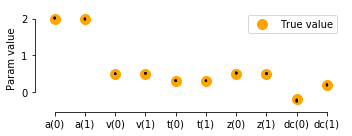

In [10]:
# plot true vs recovered parameters:
x = np.arange(5) * 2
y0 = np.array([params0['a'], params0['v'], params0['t'], params0['z'], params0['dc']])
y1 = np.array([params1['a'], params1['v'], params1['t'], params1['z'], params1['dc']])
fig = plt.figure(figsize=(5,2))
ax = fig.add_subplot(111)
ax.scatter(x, y0, marker="o", s=100, color='orange', label='True value')
ax.scatter(x+1, y1, marker="o", s=100, color='orange',)
sns.stripplot(data=params_fitted, jitter=False, size=2, edgecolor='black', linewidth=0.25, alpha=1, palette=['black', 'black'], ax=ax)
plt.ylabel('Param value')
plt.legend()
sns.despine(offset=5, trim=True,)
plt.tight_layout()



CONDITION 0
0
1
2
3


CONDITION 1
0
1
2
3


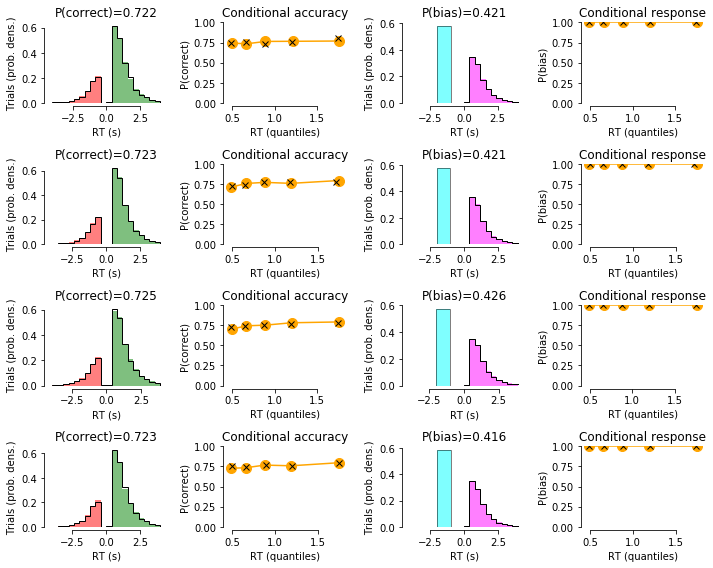

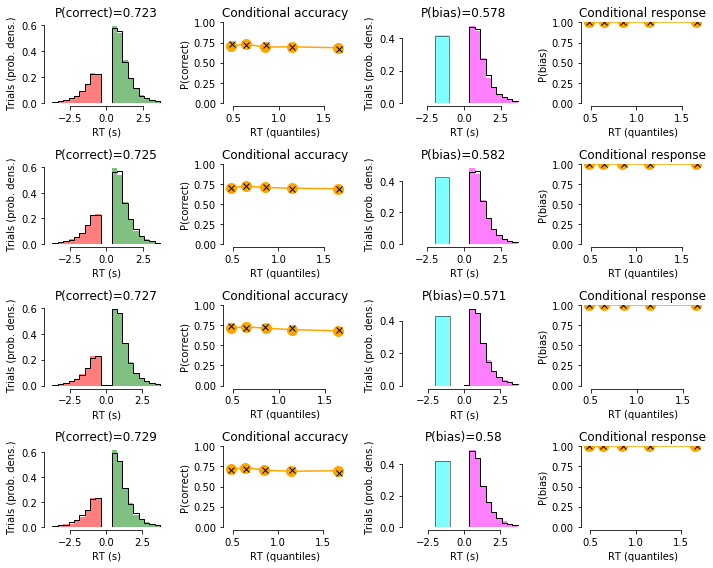

In [32]:
# plot data with model fit on top:
for c in np.unique(df_emp['condition']):
    print()
    print()
    print('CONDITION {}'.format(c))
    summary_plot(df_group=df_emp.loc[(df_emp['condition']==c),:], 
                 df_sim_group=df_sim.loc[(df_emp['condition']==c),:])